# Pure CNN using VGG16

This notebook is a simple CNN using VGG16 architecture.

In [8]:
# Libraries import
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
import numpy as np
import os
import json
from PIL import Image
from pycocotools.coco import COCO


In [2]:
# Colab setup
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    !mkdir -p ./Datasets
    # copy dataset to local dir
    !cp /content/drive/MyDrive/Datasets/YOLO_UODD_dataset.zip ./Datasets/YOLO_UODD_dataset.zip
    !unzip -q ./Datasets/YOLO_UODD_dataset.zip -d ./Datasets

In [19]:
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import CocoDetection

class UODDDataset(Dataset):
    def __init__(self, root, annotation_file, transforms=None):
        self.root = root
        self.transforms = transforms
        with open(annotation_file) as f:
            self.coco = json.load(f)
        self.ids = list(sorted(self.coco['images'], key=lambda x: x['id']))
        self.annotations = self.coco['annotations']
        # Filter images with annotations
        self.ids = [img for img in self.ids if self.has_annotations(img['id'])]

    def has_annotations(self, img_id):
        ann_ids = [ann for ann in self.annotations if ann['image_id'] == img_id]
        return len(ann_ids) > 0

    def __getitem__(self, idx):
        img_id = self.ids[idx]['id']
        img_info = self.ids[idx]
        img_path = os.path.join(self.root, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")

        ann_ids = [ann for ann in self.annotations if ann['image_id'] == img_id]
        boxes = []
        labels = []
        for ann in ann_ids:
            xmin, ymin, w, h = ann['bbox']
            boxes.append([xmin, ymin, xmin + w, ymin + h])
            labels.append(ann['category_id'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels, "image_id": torch.tensor([img_id])}

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.ids)



def get_transform():
    transforms = []
    transforms.append(F.to_tensor)
    return torchvision.transforms.Compose(transforms)

# Cell 5: Load data
train_data = UODDDataset('./Datasets/YOLO_UODD/images/train', './Datasets/YOLO_UODD/annotations/coco/instances_train.json', transforms=get_transform())
val_data = UODDDataset('./Datasets/YOLO_UODD/images/val', './Datasets/YOLO_UODD/annotations/coco/instances_val.json', transforms=get_transform())

batch_size = 2 # default one
if 'google.colab' in str(get_ipython()):
    print("Colab detected, increasing batch size to 8")
    batch_size = 8

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [20]:
print(f"Train dataset: {len(train_data)}")
print(f"Validation dataset: {len(val_data)}")

Train dataset: 2558
Validation dataset: 128


In [21]:
from torchvision.models import VGG16_Weights

backbone = torchvision.models.vgg16(weights=VGG16_Weights.DEFAULT).features
backbone.out_channels = 512

# Define the RPN anchor generator
rpn_anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),) * 5
)

# Define the RoI pooler
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)

# Create the Faster R-CNN model
model = FasterRCNN(backbone, num_classes=5,
                   rpn_anchor_generator=rpn_anchor_generator,
                   box_roi_pool=roi_pooler)

# Training setup
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(in

In [17]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training function with progress bar and loss printing
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    running_loss = 0.0
    num_batches = len(data_loader)
    progress_bar = tqdm(data_loader, desc=f"Epoch {epoch+1}", unit="batch")

    for images, targets in progress_bar:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        running_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        progress_bar.set_postfix(loss=losses.item())

    epoch_loss = running_loss / num_batches
    print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f}")

# Training loop with tqdm progress bar
num_epochs = 2
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
    lr_scheduler.step()

# Save the model
torch.save(model.state_dict(), 'fasterrcnn_vgg16_uodd.pth')

print("Training complete. Model saved as 'fasterrcnn_vgg16_uodd.pth'.")

Epoch 1:   2%|▏         | 21/1279 [00:09<09:03,  2.32batch/s, loss=3.18]  


KeyboardInterrupt: 

In [18]:
if 'google.colab' in str(get_ipython()):
  !cp -rf ./fasterrcnn_vgg16_uodd.pth /content/drive/MyDrive/Models/fasterrcnn_vgg16_uodd.pth

In [25]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

In [27]:
from tqdm import tqdm
import torch
import torchvision
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import json

model.load_state_dict(torch.load('fasterrcnn_vgg16_uodd.pth'))

val_root = './Datasets/YOLO_UODD/images/val'
val_annFile = './Datasets/YOLO_UODD/annotations/coco/instances_val.json'
val_dataset = UODDDataset(val_root, val_annFile, transforms=get_transform())
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Function to evaluate the model
def evaluate(model, data_loader, device):
    model.eval()
    coco = COCO(val_annFile)
    results = []

    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Evaluating"):
            images = list(img.to(device) for img in images)
            outputs = model(images)

            for target, output in zip(targets, outputs):
                image_id = target["image_id"].item()
                boxes = output["boxes"].cpu().numpy()
                scores = output["scores"].cpu().numpy()
                labels = output["labels"].cpu().numpy()

                for box, score, label in zip(boxes, scores, labels):
                    result = {
                        "image_id": image_id,
                        "category_id": label,
                        "bbox": box.tolist(),
                        "score": score
                    }
                    results.append(result)

    # Save results in COCO format
    with open("results.json", "w") as f:
        json.dump(results, f, cls=NpEncoder)

    coco_dt = coco.loadRes("results.json")
    coco_eval = COCOeval(coco, coco_dt, iouType='bbox')

    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    # Extract metrics
    precision = coco_eval.stats[0]  # Precision @ IoU=0.50
    recall = coco_eval.stats[1]     # Recall @ IoU=0.50
    mAP_50 = coco_eval.stats[1]     # mAP @ IoU=0.50
    mAP_50_95 = coco_eval.stats[0]  # mAP @ IoU=0.50:0.95

    return precision, recall, mAP_50, mAP_50_95

# Evaluate the model
precision, recall, mAP_50, mAP_50_95 = evaluate(model, val_loader, device)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"mAP@50: {mAP_50:.4f}")
print(f"mAP@50-95: {mAP_50_95:.4f}")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Evaluating: 100%|██████████| 64/64 [00:09<00:00,  6.59it/s]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.17s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


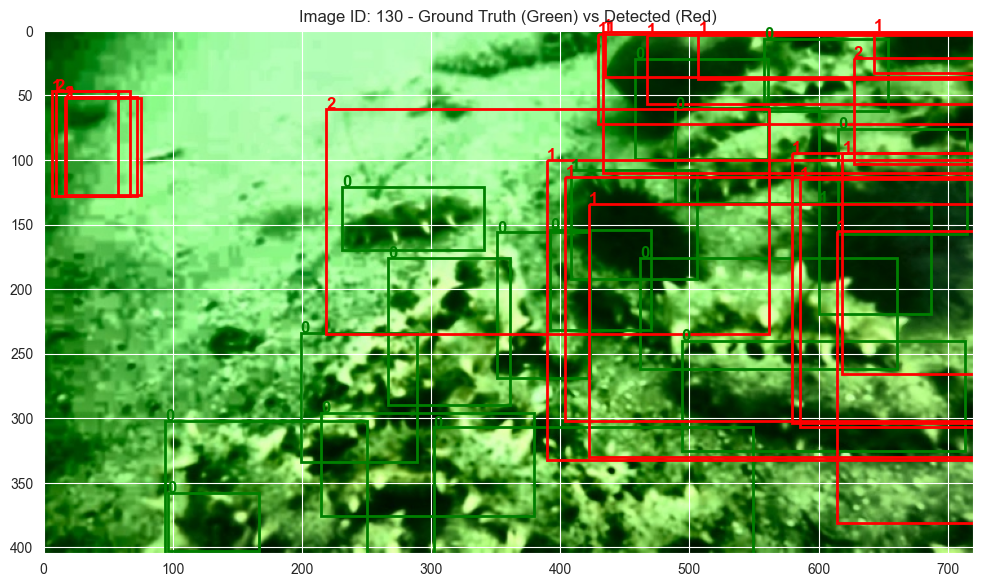

In [38]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from pycocotools.coco import COCO

# Function to load COCO annotations for a specific image
def load_annotations(coco, image_id):
    ann_ids = coco.getAnnIds(imgIds=image_id)
    annotations = coco.loadAnns(ann_ids)
    boxes = [ann['bbox'] for ann in annotations]
    categories = [ann['category_id'] for ann in annotations]
    return boxes, categories

# Function to plot ground truth and detected bounding boxes with category IDs
def plot_image_with_boxes(image_path, ground_truth_boxes, ground_truth_labels, detected_boxes, detected_labels, title):
    img = Image.open(image_path).convert("RGB")
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)

    for box, label in zip(ground_truth_boxes, ground_truth_labels):
        xmin, ymin, width, height = box
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        plt.text(xmin, ymin, f'{label}', color='g', fontsize=12, weight='bold')

    for box, label in zip(detected_boxes, detected_labels):
        xmin, ymin, width, height = box
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(xmin, ymin, f'{label}', color='r', fontsize=12, weight='bold')

    plt.title(title)
    plt.show()

# Load COCO validation annotations
coco = COCO(val_annFile)

# Load detection results
with open("results.json") as f:
    detection_results = json.load(f)

# Select an image to visualize (you can choose any image ID)
image_id = detection_results[15]['image_id']
image_info = coco.loadImgs(image_id)[0]
image_path = os.path.join(val_root, image_info['file_name'])

# Load ground truth boxes and labels
ground_truth_boxes, ground_truth_labels = load_annotations(coco, image_id)

# Load detected boxes and labels
detected_boxes = [res['bbox'] for res in detection_results if res['image_id'] == image_id]
detected_labels = [res['category_id'] for res in detection_results if res['image_id'] == image_id]

# Plot the image with ground truth and detected boxes and labels
plot_image_with_boxes(image_path, ground_truth_boxes, ground_truth_labels, detected_boxes, detected_labels, title=f"Image ID: {image_id} - Ground Truth (Green) vs Detected (Red)")
